# Лабораторная работа №2: Решение СЛАУ разными методами. Вариант К 
## Клименко Виталий, Б01-203

1. Имеем систему уравнений вида:

$a_{11}x_1 + a_{12}x_2 + ... + a_{1n}x_n = f_1$

...

$a_{n1}x_1 + a_{n2}x_2 + ... + a_{nn}x_n = f_n$                  

причём параметры системы задаются следующим образом:

$n = 10$, $a_{ii} = 1$, $a_{ij}=1/(i+j)$, $f_i=1/j$


В лабораторной работе будут реализованы следующие методы:
1) метод Гаусса с выбором главного элемента
2) метод LU-разложения (если применим)
3) метод Якоби
4) метод Зейделя
5) метод верхней релаксации

Для удобства определим некоторые функции:

Произведение скаляра на вектор:

In [22]:
def scalar_x_vector_multiplication(scalar, vector):
    return [scalar * v for v in vector]

Скалярное произведение

In [23]:
def dot_product(v1, v2):
    return sum(v1[i] * v2[i] for i in range(len(v1)))

Разность векторов

In [24]:
def vect_diff(v1, v2):
    return [v1[i] - v2[i] for i in range(len(v1))]

Произведение матрицы и вектора

In [25]:
def matrix_x_vector_multiplication(A, x):
    return [sum(A[i][j] * x[j] for j in range(len(x))) for i in range(len(A))]

## Ход работы

# 1. Метод Гаусса

In [26]:
import numpy as np

n = 10
A = np.zeros((n, n))
f = np.zeros(n)

# Заполним матрицу A и приведём в соответствие каждому i своё f[i]:
for i in range(n):
    for j in range(n):
        if i == j:
            A[i][j] = 1
        else:
            A[i][j] = 1 / (i + j + 2)
    f[i] = 1 / (i + 1)

def gauss_elimination(A, f):
    n = len(f)
    for i in range(n):
        max_row_index = np.argmax(np.abs(A[i:, i])) + i
        A[[i, max_row_index]] = A[[max_row_index, i]]
        f[[i, max_row_index]] = f[[max_row_index, i]]
        
        for j in range(i + 1, n):
            factor = A[j][i] / A[i][i]
            A[j] -= factor * A[i]
            f[j] -= factor * f[i]
    
    x = np.zeros(n) # и обратный ход
    for i in range(n - 1, -1, -1):
        x[i] = (f[i] - np.dot(A[i], x)) / A[i][i]
    
    return x

solution_gauss = gauss_elimination(A.copy(), f.copy())

print("Решение методом Гаусса:")
for i in range(n):
    print(f"x[{i+1}] = {solution_gauss[i]:.15f}")

Решение методом Гаусса:
x[1] = 0.919077109266920
x[2] = 0.175540170493088
x[3] = 0.063934824014441
x[4] = 0.027274763960846
x[5] = 0.011423468535555
x[6] = 0.003510839278717
x[7] = -0.000789957813856
x[8] = -0.003250801449485
x[9] = -0.004697877810512
x[10] = -0.005553739941266


# 2. LU разложение

In [27]:
def lu_decomposition(A):
    n = len(A)
    L = [[0.0] * n for _ in range(n)] #объявляем матрицы
    U = [[0.0] * n for _ in range(n)]

    for i in range(n): # и заполняем их
        for j in range(n):
            if i <= j:
                U[i][j] = A[i][j]
                for k in range(i):
                    U[i][j] -= L[i][k] * U[k][j]
            else:
                L[i][j] = A[i][j]
                for k in range(j):
                    L[i][j] -= L[i][k] * U[k][j]
                L[i][j] /= U[j][j]

        L[i][i] = 1.0

    return L, U

def forward_substitution(L, f):
    n = len(L)
    y = [0.0] * n
    for i in range(n):
        y[i] = f[i]
        for j in range(i):
            y[i] -= L[i][j] * y[j]
    return y

def backward_substitution(U, y):
    n = len(U)
    x = [0.0] * n
    for i in range(n - 1, -1, -1):
        x[i] = y[i]
        for j in range(i + 1, n):
            x[i] -= U[i][j] * x[j]
        x[i] /= U[i][i]
    return x

L, U = lu_decomposition(A)

y = forward_substitution(L, f)

solution_LU = backward_substitution(U, y)

print("Решение системы методом LU-разложения:")
for i in range(n):
    print(f"x[{i+1}] = {solution_LU[i]:.15f}")

Решение системы методом LU-разложения:
x[1] = 0.919077109266921
x[2] = 0.175540170493088
x[3] = 0.063934824014441
x[4] = 0.027274763960846
x[5] = 0.011423468535555
x[6] = 0.003510839278717
x[7] = -0.000789957813856
x[8] = -0.003250801449485
x[9] = -0.004697877810512
x[10] = -0.005553739941266


# 3. Метод Якоби

In [28]:
def jacobi_method(A, f, tol=1e-10, max_iterations=1000):
    n = len(f)
    x_old = [0.0] * n
    residuals = []

    for iteration in range(max_iterations):
        x_new = [0.0] * n
        
        for i in range(n):
            sum_j = sum(A[i][j] * x_old[j] for j in range(n) if j != i)
            x_new[i] = (f[i] - sum_j) / A[i][i]
        
        r = vect_diff(f, matrix_x_vector_multiplication(A, x_new))
        residuals.append((dot_product(r, r)) ** 0.5)

        if np.linalg.norm(vect_diff(x_new, x_old)) < tol:
            break
        
        x_old = x_new

    return x_new, residuals

solution_jacobi, residuals_jacobi = jacobi_method(A.copy(), f.copy())

print("Решения методом Якоби:")
for i in range(n):
    print(f"x[{i + 1}] = {solution_jacobi[i]:.15f}")

Решения методом Якоби:
x[1] = -79903748523087577088.000000000000000
x[2] = -73520447180669722624.000000000000000
x[3] = -64780838619418566656.000000000000000
x[4] = -57411378486998409216.000000000000000
x[5] = -51437056283219943424.000000000000000
x[6] = -46562062466655150080.000000000000000
x[7] = -42526721095012777984.000000000000000
x[8] = -39136938117569052672.000000000000000
x[9] = -36251020485750505472.000000000000000
x[10] = -33764831090874499072.000000000000000


# 4. Метод Зейделя

In [29]:
def seidel_method(A, f, tol=1e-10, max_iterations=1000):
    n = len(f)
    x_old = [0.0] * n
    residuals = []

    for iteration in range(max_iterations):
        x_new = [0.0] * n
        
        for i in range(n):
            sum_lower = sum(A[i][j] * x_new[j] for j in range(i))
            sum_upper = sum(A[i][j] * x_old[j] for j in range(i + 1, n))
            x_new[i] = (f[i] - sum_lower - sum_upper) / A[i][i]
        
        r = vect_diff(f, matrix_x_vector_multiplication(A, x_new))
        residuals.append((dot_product(r, r)) ** 0.5)

        if np.linalg.norm(vect_diff(x_new, x_old)) < tol:
            break
        
        x_old = x_new

    return x_new, residuals

solution_seidel, residuals_seidel = seidel_method(A.copy(), f.copy())

print("Решения методом Зейделя:")
for i in range(n):
    print(f"x[{i + 1}] = {solution_seidel[i]:.15f}")

Решения методом Зейделя:
x[1] = 0.919077109272549
x[2] = 0.175540170491198
x[3] = 0.063934824012020
x[4] = 0.027274763958825
x[5] = 0.011423468534075
x[6] = 0.003510839277733
x[7] = -0.000789957814429
x[8] = -0.003250801449735
x[9] = -0.004697877810513
x[10] = -0.005553739941082


# 5. Метод верхней релаксации

In [30]:
def sor_method(A, f, omega=1.25, tol=1e-10, max_iterations=1000):
    n = len(f)
    x_old = np.zeros(n)

    for iteration in range(max_iterations):
        x_new = np.zeros(n)

        for i in range(n):
            sum_lower = sum(A[i][j] * x_new[j] for j in range(i))
            sum_upper = sum(A[i][j] * x_old[j] for j in range(i + 1, n))
            x_new[i] = (1 - omega) * x_old[i] + omega * (f[i] - sum_lower - sum_upper) / A[i][i]
        
        if np.linalg.norm(x_new - x_old, ord=np.inf) < tol:
            break
        
        x_old = x_new
    
    return x_new


solution_sor = sor_method(A.copy(), f.copy())

print("Решения методом верхней релаксации:")
for i in range(n):
    print(f"x[{i + 1}] = {solution_sor[i]:.15f}")

Решения методом верхней релаксации:
x[1] = 0.919077109318133
x[2] = 0.175540170505087
x[3] = 0.063934824011258
x[4] = 0.027274763952479
x[5] = 0.011423468525799
x[6] = 0.003510839269152
x[7] = -0.000789957822568
x[8] = -0.003250801457094
x[9] = -0.004697877816961
x[10] = -0.005553739946592


# 6. Метод градиентного спуска

In [31]:
def gradient_descent(A, f, alpha=0.01, tol=1e-10, max_iterations=1000):
    n = len(f)
    x_old = np.zeros(n)

    for k in range(max_iterations):
        r = f - A @ x_old
        grad_f = -A.T @ r
        
        # Обновление решения
        x_new = x_old - alpha * grad_f
        
        if np.linalg.norm(x_new - x_old) < tol:
            break
        
        x_old = x_new
    
    return x_new

solution_gradient_descent = gradient_descent(A.copy(), f.copy())
print("Решение системы методом градиентного спуска:")
for i in range(n):
    print(f"x[{i}] = {solution_gradient_descent[i]:.15f}")

Решение системы методом градиентного спуска:
x[0] = 0.912922109384645
x[1] = 0.179997357621069
x[2] = 0.065444721157897
x[3] = 0.027959464592362
x[4] = 0.011766268286248
x[5] = 0.003681449486908
x[6] = -0.000716235664510
x[7] = -0.003235506962283
x[8] = -0.004719449282758
x[9] = -0.005599265547197


# 7. Убытие невязки

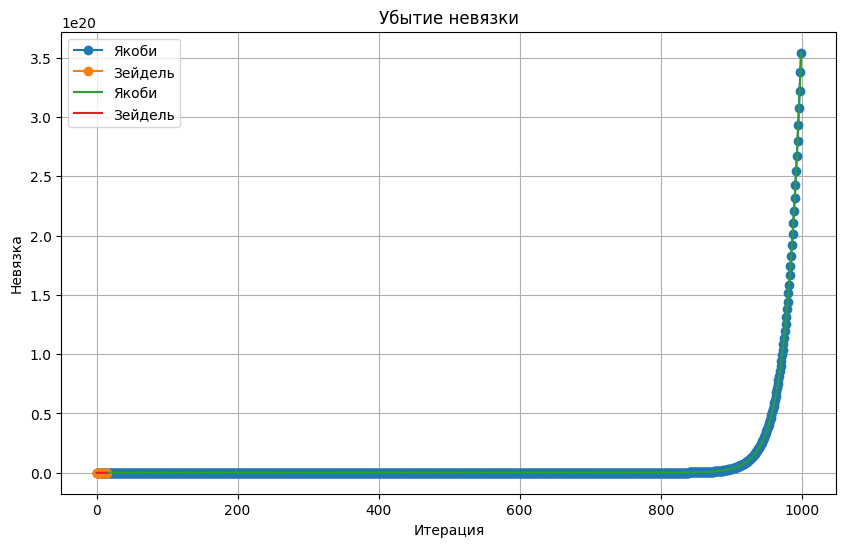

In [32]:
import matplotlib.pyplot as plt

# Функция для построения графиков невязки
def plot_residuals(residuals_list):
    plt.figure(figsize=(10, 6))
    
    for label, residuals in residuals_list.items():
        plt.plot(residuals, marker='o', label=label)

    for label, residuals in residuals_list.items():
        plt.plot(residuals, label=label)

    plt.xlabel('Итерация')
    plt.ylabel('Невязка')
    plt.title('Убытие невязки')
    plt.legend()
    plt.grid()
    plt.show()

# Построение графиков для методов Якоби и Зейделя
plot_residuals({
   'Якоби': residuals_jacobi,
   'Зейдель': residuals_seidel,
})

# Аналитика результатов:

Метод Гаусса, LU-разложения, Зейделя и верхней релаксации дали идентичные результаты. А вот метод Якоби показал другой результат. Могу объяснить это тем, что для данной СЛАУ метод Якоби не сходится, потому что для метода Зейделя, который реализуется похожим образом результат сошёлся.